# Resonant cavity - Discussion

In [30]:
# Temporary 'hack' for working directory not coinciding with file directory
import os
os.chdir('/home/fenics/shared/examples/resonant_cavity')

# Needed for plotting
import pickle
root = os.path.abspath(os.path.join('__file__' ,'../../..'))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
cm = matplotlib.cm.get_cmap('inferno')

import fenics as fen
import mshr
from two_dimensional_cavity import TwoDimensionalCavity
from rectangular_cavity import RectangularCavity

from context import src
from src.vector_space import VectorSpaceL2
from src.minimal_rational_interpolation import MinimalRationalInterpolation
import src.helpers as helpers

## Rectangular cavity

In [32]:
Lx, Ly = 5.0, 1.0
Nx, Ny = 101, 21
m = 1
g_N = fen.Expression('sin(x[1]*m*pi/Ly)', degree=2, Ly=Ly, m=m)
RC = RectangularCavity(Lx=Lx, Ly=Ly, Nx=Nx, Ny=Ny, g_N=g_N)
RC.setup()
#RC.plot_g_N()

class inlet(fen.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and fen.near(x[0], 0.0) and x[1]>0.0 and x[1]<Ly

### Full cavity

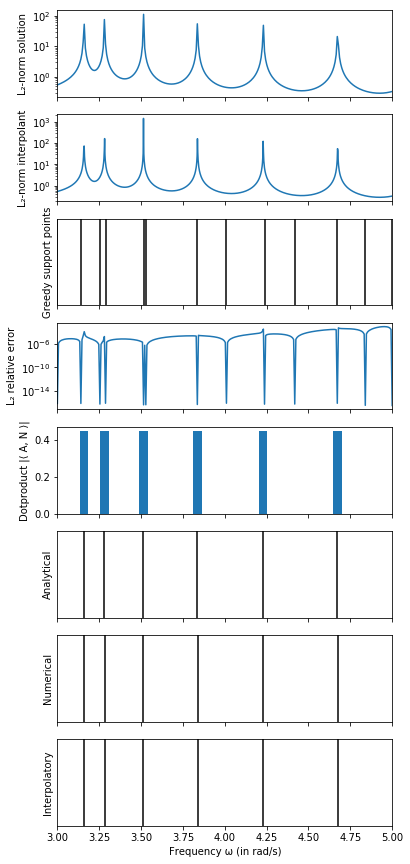

In [25]:
fig, ax = plt.subplots(8, 1, figsize=(6, 15), sharex=True)

a = 3
b = 5
omegas = np.linspace(a, b, 300)
RC.solve(omegas, solver='fenics')
solution = RC.save_solution()
VS = VectorSpaceL2(RC)

ax[0].set_ylabel('L\u2082-norm solution')
helpers.plot_solution_norms(ax[0], solution, VS)

MRI = MinimalRationalInterpolation(VS)
MRI.compute_surrogate(RC, omegas=omegas, greedy=True, tol=1e-1)

ax[1].set_ylabel('L\u2082-norm interpolant')
helpers.plot_surrogate_norms(ax[1], MRI, a, b)

ax[2].set_ylabel('Greedy support points')
helpers.plot_lines(ax[2], MRI.u_ring.get_nodes())

ax[3].set_ylabel('L\u2082 relative error')
helpers.plot_surrogate_error_norms(ax[3], solution, MRI, VS)

eigfreqs, eigvecs = RC.get_numerical_eigenfrequencies(a, b, return_eigvecs=True)

ax[4].set_ylabel('Dotproduct |\u27E8 A, N \u27E9|')
ax[4].bar(eigfreqs, np.abs([np.inner(RC.insert_boundary_values(eigvec), RC.get_N()) for eigvec in eigvecs]), width=0.05)

ax[5].set_ylabel('Analytical')
helpers.plot_lines(ax[5], RC.get_analytical_eigenfrequencies(a, b))

ax[6].set_ylabel('Numerical')
helpers.plot_lines(ax[6], eigfreqs)

ax[7].set_ylabel('Interpolatory')
helpers.plot_lines(ax[7], MRI.get_interpolatory_eigenfrequencies(only_real=True))

ax[-1].set_xlabel('Frequency \u03C9 (in rad/s)')
ax[-1].set_xlim(a, b)
plt.show()

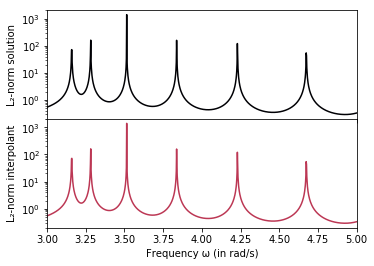

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(5.55, 4), sharex=True)#), gridspec_kw={'height_ratios': [10, 10, 1]})

a = 3
b = 5
omegas = np.linspace(a, b, 1000)
RC.solve(omegas, solver='fenics')
solution = RC.save_solution()
VS = VectorSpaceL2(RC)

ax[0].set_ylabel('L\u2082-norm solution')
FE_norms = helpers.plot_solution_norms(ax[0], solution, VS, color=cm(0.0))

MRI = MinimalRationalInterpolation(VS)
MRI.compute_surrogate(RC, omegas=omegas, greedy=True, tol=1e-2)

ax[1].set_ylabel('L\u2082-norm interpolant')
RI_norms = helpers.plot_surrogate_norms(ax[1], MRI, a, b, color=cm(0.5))

#nodes = MRI.u_ring.get_nodes()
#ax[-1].scatter(nodes, np.zeros_like(nodes), s=10, color=cm(0.5))
#helpers.plot_lines(ax[1], MRI.u_ring.get_nodes())

#ax[-1].set_yticks([])
ax[-1].set_xlabel('Frequency \u03C9 (in rad/s)')
ax[-1].set_xlim(a, b)
ax[0].set_ylim(2e-1, 2e+3)
ax[1].set_ylim(2e-1, 2e+3)
plt.subplots_adjust(wspace=0, hspace=0)

In [14]:
with open(root + '/report/plots/rectangular_cavity_norms.pkl', 'wb') as f:
    pickle.dump([FE_norms, RI_norms, omegas], f) 

#### Progression of relative error in greedy MRI

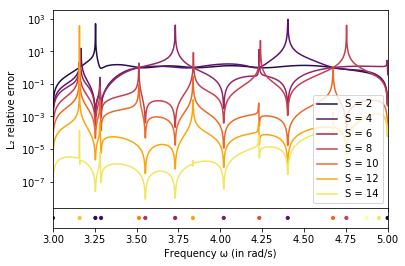

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True, gridspec_kw={'height_ratios': [10, 1]})

omegas = np.linspace(a, b, 1000)
linspace = np.linspace(a-(b-a)/2000, b+(b-a)/2000, 1001)
RC.solve(linspace)
u_linspace = RC.get_solution(trace=VS.get_trace())

MRI = MinimalRationalInterpolation(VS)
n_iter = 16
surrogate_history = MRI.compute_surrogate(RC, omegas, greedy=True, n_iter=n_iter, return_history=True)

# FOR PLOTTING ONLY
norms = []
n_supp = range(n_iter - 1)[2::2]
for i in n_supp:
    RI = surrogate_history[i-2]
    norms.append(helpers.plot_surrogate_error_norms(ax[0], RC, MRI, VS, u_linspace, linspace, RI,
        label='S = {}'.format(i), color=cm(i/(n_iter-1))))
nodes = MRI.u_ring.get_nodes()
ax[1].scatter(nodes, np.zeros_like(nodes), s=10, c=cm(np.arange(len(nodes))/(n_iter-1)), zorder=-n_iter)
ax[0].set_ylabel('L\u2082 relative error')
ax[1].set_xlabel('Frequency \u03C9 (in rad/s)')
ax[1].set_xlim(a, b)
ax[1].set_yticks([])
ax[0].legend()
plt.subplots_adjust(wspace=0, hspace=0)

In [16]:
with open(root + '/report/plots/rectangular_cavity_errorprogression.pkl', 'wb') as f:
    pickle.dump([norms, linspace, n_supp, n_iter, nodes, a, b], f) 

#### Analyzing symmetry of eigenmodes

/home/fenics/shared/examples/resonant_cavity/rectangular_cavity.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  u_func.vector()[:] = u_vec


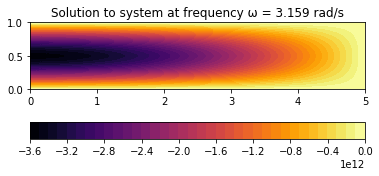

In [60]:
eigfreqs, eigvecs = RC.get_numerical_eigenfrequencies(a, b, return_eigvecs=True)

omega = eigfreqs[0]
RC.solve(omega)
RC.plot_solution(cmap=cm)

In [61]:
solution = RC.get_solution()
coords = RC.V.tabulate_dof_coordinates().reshape((-1, 2))
with open(root + '/report/plots/rectangular_cavity_mode1.pkl', 'wb') as f:
    pickle.dump([solution, coords, omega], f)

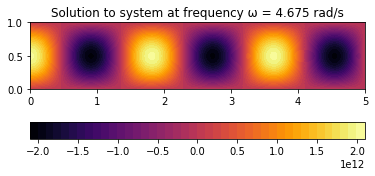

In [62]:
eigfreqs, eigvecs = RC.get_numerical_eigenfrequencies(a, b, return_eigvecs=True)

omega = eigfreqs[5]
RC.solve(omega)
RC.plot_solution(cmap=cm)

In [63]:
solution = RC.get_solution()
coords = RC.V.tabulate_dof_coordinates().reshape((-1, 2))
with open(root + '/report/plots/rectangular_cavity_mode5.pkl', 'wb') as f:
    pickle.dump([solution, coords, omega], f)

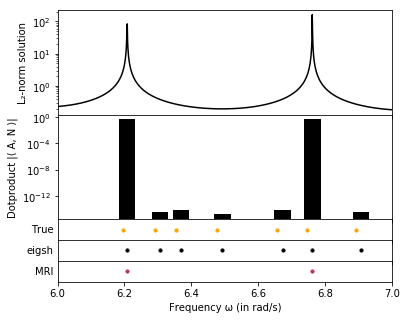

In [28]:
fig, ax = plt.subplots(5, 1, figsize=(6, 5), sharex=True, gridspec_kw={'height_ratios': [5, 5, 1, 1, 1]})

a = 6
b = 7
omegas = np.linspace(a, b, 1000)
RC.solve(omegas, solver='fenics')
solution = RC.save_solution()
VS = VectorSpaceL2(RC)

ax[0].set_ylabel('L\u2082-norm solution')
norms = helpers.plot_solution_norms(ax[0], solution, VS, color='k')

MRI = MinimalRationalInterpolation(VS)
MRI.compute_surrogate(RC, omegas=omegas, greedy=True, tol=1e-2)

eigfreqs_numerical, eigvecs_numerical = RC.get_numerical_eigenfrequencies(a, b, return_eigvecs=True, k=20)

ax[1].set_ylabel('Dotproduct |\u27E8 A, N \u27E9|')
dotproducts = np.abs([np.inner(RC.insert_boundary_values(eigvec), RC.get_N()) for eigvec in eigvecs_numerical])
ax[1].bar(eigfreqs_numerical, dotproducts, width=0.05, color='k')
ax[1].set_yscale('log')

ax[2].set_ylabel('True', rotation=0, ha='right', va='center')
eigfreqs_analytical = RC.get_analytical_eigenfrequencies(a, b)
ax[2].scatter(eigfreqs_analytical, np.zeros_like(eigfreqs_analytical), s=10, color=cm(0.8))
ax[2].set_yticks([])

ax[3].set_ylabel('eigsh', rotation=0, ha='right', va='center')
ax[3].scatter(eigfreqs_numerical, np.zeros_like(eigfreqs_numerical), s=10, color=cm(0.0))
ax[3].set_yticks([])

ax[4].set_ylabel('MRI', rotation=0, ha='right', va='center')
eigfreqs_rational = MRI.get_interpolatory_eigenfrequencies(only_real=True)
ax[4].scatter(eigfreqs_rational, np.zeros_like(eigfreqs_rational), s=10, color=cm(0.5))
ax[4].set_yticks([])

ax[-1].set_xlabel('Frequency \u03C9 (in rad/s)')
ax[-1].set_xlim(a, b)

plt.subplots_adjust(wspace=0, hspace=0)

In [29]:
with open(root + '/report/plots/rectangular_cavity_suppressed.pkl', 'wb') as f:
    pickle.dump([omegas, norms, dotproducts, eigfreqs_analytical, eigfreqs_numerical, eigfreqs_rational], f)

### Inlet of cavity

Relative range of singular values is 1.50e+13.
Relative range of singular values is 2.79e+13.
Relative range of singular values is 3.01e+13.
Relative range of singular values is 3.09e+13.
Relative range of singular values is 3.10e+13.
Relative range of singular values is 3.32e+13.
Relative range of singular values is 3.42e+13.
Relative range of singular values is 3.85e+13.
Relative range of singular values is 3.83e+13.
Relative range of singular values is 3.96e+13.
Relative range of singular values is 4.13e+13.
Relative range of singular values is 4.26e+13.
Relative range of singular values is 1.08e+14.
Relative range of singular values is 1.55e+14.
Relative range of singular values is 1.66e+14.
Relative range of singular values is 1.75e+14.
Relative range of singular values is 1.79e+13.
Relative range of singular values is 1.67e+13.


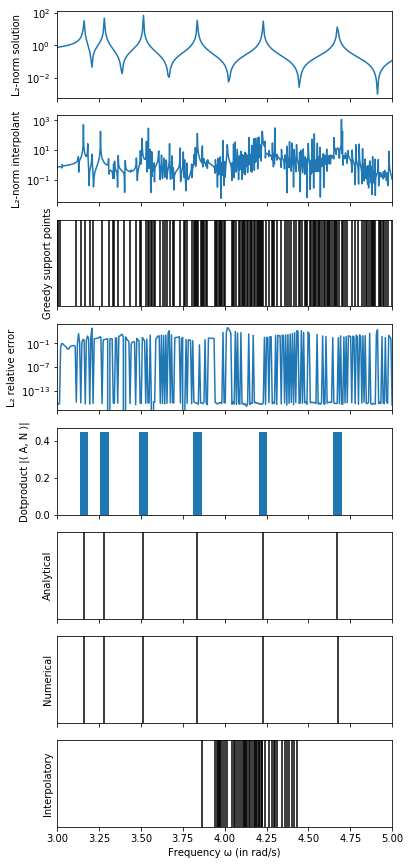

In [7]:
fig, ax = plt.subplots(8, 1, figsize=(6, 15), sharex=True)

a = 3
b = 5
omegas = np.linspace(a, b, 300)
RC.solve(omegas)
solution = RC.save_solution(trace=inlet())
VS = VectorSpaceL2(RC, inlet())
MRI = MinimalRationalInterpolation(VS)
MRI.compute_surrogate(RC, omegas=omegas, greedy=True, tol=1e-1)

ax[0].set_ylabel('L\u2082-norm solution')
helpers.plot_solution_norms(ax[0], solution, VS)

ax[1].set_ylabel('L\u2082-norm interpolant')
helpers.plot_surrogate_norms(ax[1], MRI, a, b)

ax[2].set_ylabel('Greedy support points')
helpers.plot_lines(ax[2], MRI.u_ring.get_nodes())

ax[3].set_ylabel('L\u2082 relative error')
helpers.plot_surrogate_error_norms(ax[3], solution, MRI, VS)

eigfreqs, eigvecs = RC.get_numerical_eigenfrequencies(a, b, return_eigvecs=True)

ax[4].set_ylabel('Dotproduct |\u27E8 A, N \u27E9|')
ax[4].bar(eigfreqs, np.abs([np.inner(RC.insert_boundary_values(eigvec), RC.get_N()) for eigvec in eigvecs]), width=0.05)

ax[5].set_ylabel('Analytical')
helpers.plot_lines(ax[5], RC.get_analytical_eigenfrequencies(a, b))

ax[6].set_ylabel('Numerical')
helpers.plot_lines(ax[6], eigfreqs)

ax[7].set_ylabel('Interpolatory')
helpers.plot_lines(ax[7], MRI.get_interpolatory_eigenfrequencies(only_real=True))

ax[-1].set_xlabel('Frequency \u03C9 (in rad/s)')
ax[-1].set_xlim(a, b)
plt.show()

Standard deviation of trace-quotient: 1.20e-15


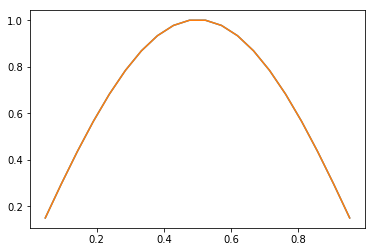

In [8]:
fig, ax = plt.subplots(1, 1)
RC.solve(eigfreqs)
x = RC.get_solution(trace=inlet())
all_coords = RC.V.tabulate_dof_coordinates()
trace_coords = np.array([x for x in all_coords if inlet().inside(x, 'on_boundary')])
ax.plot(trace_coords[:, 1], np.abs(x[0])/np.max(np.abs(x[0])))
ax.plot(trace_coords[:, 1], np.abs(x[1])/np.max(np.abs(x[1])))
print('Standard deviation of trace-quotient: {:.2e}'.format(np.std(x[1] / x[0])))

## Rectangular cavity with cubby (breaking symmetry)

In [60]:
Lx, Ly = 5.0, 1.0

domain = mshr.Rectangle(fen.Point(0.0, 0.0), fen.Point(Lx, Ly)) \
       + mshr.Rectangle(fen.Point(Lx*0.5, Ly), fen.Point(Lx*0.75, Ly*1.05))
mesh = mshr.generate_mesh(domain, 100)

class inlet(fen.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and fen.near(x[0], 0.0) and x[1]>0.0 and x[1]<Ly

m = 1
g_N = fen.Expression('sin(x[1]*m*pi/Ly)', degree=2, Ly=Ly, m=m)
TDC = TwoDimensionalCavity(mesh=mesh, B_N=inlet, g_N=g_N)
TDC.setup()

Relative range of singular values is 1.87e+13.
Relative range of singular values is 2.58e+13.
Relative range of singular values is 2.56e+13.
Relative range of singular values is 2.20e+13.
Relative range of singular values is 2.38e+13.
Relative range of singular values is 2.39e+13.
Relative range of singular values is 8.12e+13.


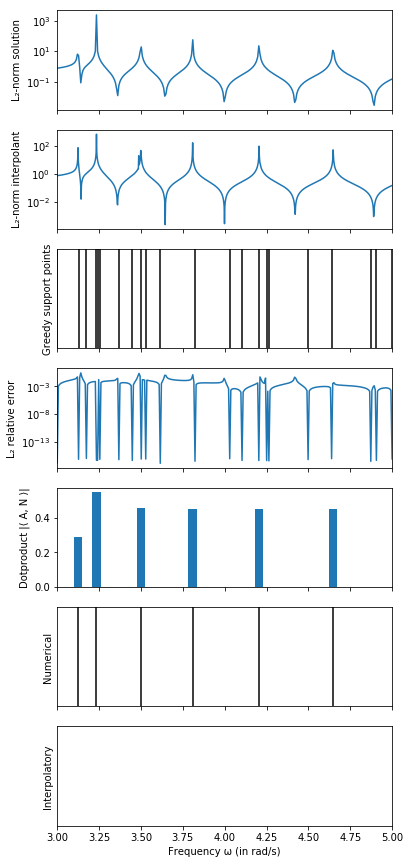

In [101]:
fig, ax = plt.subplots(7, 1, figsize=(6, 15), sharex=True)

a = 3
b = 5
omegas = np.linspace(a, b, 300)
TDC.solve(omegas)
solution = TDC.save_solution(trace=inlet())
VS = VectorSpaceL2(TDC, inlet())
MRI = MinimalRationalInterpolation(VS)
MRI.compute_surrogate(TDC, omegas=omegas, greedy=True, tol=5e-1)

ax[0].set_ylabel('L\u2082-norm solution')
helpers.plot_solution_norms(ax[0], solution, VS)

ax[1].set_ylabel('L\u2082-norm interpolant')
helpers.plot_surrogate_norms(ax[1], MRI, a, b)

ax[2].set_ylabel('Greedy support points')
helpers.plot_lines(ax[2], MRI.u_ring.get_nodes())

ax[3].set_ylabel('L\u2082 relative error')
helpers.plot_surrogate_error_norms(ax[3], solution, MRI, VS)

eigfreqs, eigvecs = TDC.get_numerical_eigenfrequencies(a, b, return_eigvecs=True)

ax[4].set_ylabel('Dotproduct |\u27E8 A, N \u27E9|')
ax[4].bar(eigfreqs, np.abs([np.inner(TDC.insert_boundary_values(eigvec), TDC.get_N()) for eigvec in eigvecs]), width=0.05)

ax[5].set_ylabel('Numerical')
helpers.plot_lines(ax[5], eigfreqs)

ax[6].set_ylabel('Interpolatory')
helpers.plot_lines(ax[6], MRI.get_interpolatory_eigenfrequencies(only_real=True))

ax[-1].set_xlabel('Frequency \u03C9 (in rad/s)')
ax[-1].set_xlim(a, b)
plt.show()

Standard deviation of trace-quotient: 6.97e-04


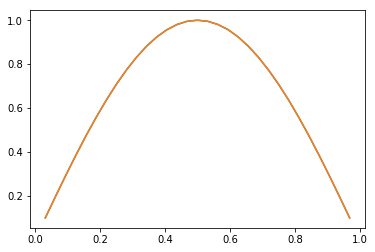

In [102]:
fig, ax = plt.subplots(1, 1)
TDC.solve(eigfreqs)
x = TDC.get_solution(trace=inlet())
all_coords = TDC.V.tabulate_dof_coordinates()
trace_coords = np.array([x for x in all_coords if inlet().inside(x, 'on_boundary')])
idx_sorted = sorted(range(len(trace_coords)), key=trace_coords[:, 1].__getitem__)
x0_sorted = [x[0, i] for i in idx_sorted]
x1_sorted = [x[1, i] for i in idx_sorted]
ax.plot(trace_coords[idx_sorted, 1], np.abs(x0_sorted)/np.max(np.abs(x[0])))
ax.plot(trace_coords[idx_sorted, 1], np.abs(x1_sorted)/np.max(np.abs(x[1])))
print('Standard deviation of trace-quotient: {:.2e}'.format(np.std(x[1] / x[0])))

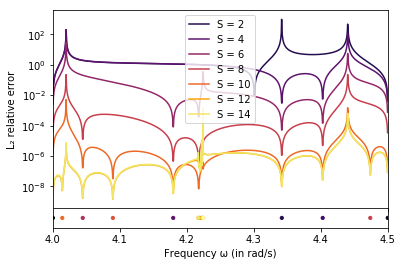

In [68]:
fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True, gridspec_kw={'height_ratios': [10, 1]})

Lx, Ly = 5.0, 1.0

domain = mshr.Rectangle(fen.Point(0.0, 0.0), fen.Point(Lx, Ly)) \
       + mshr.Rectangle(fen.Point(Lx*0.5, Ly), fen.Point(Lx*0.75, Ly*1.01))
mesh = mshr.generate_mesh(domain, 100)

class inlet(fen.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and fen.near(x[0], 0.0) and x[1]>0.0 and x[1]<Ly

m = 1
g_N = fen.Expression('sin(x[1]*m*pi/Ly)', degree=2, Ly=Ly, m=m)
TDC = TwoDimensionalCavity(mesh=mesh, B_N=inlet, g_N=g_N)
TDC.setup()

VS = VectorSpaceL2(TDC, inlet())
a = 4
b = 4.5
omegas = np.linspace(a, b, 1000)
linspace = np.linspace(a-(b-a)/2000, b+(b-a)/2000, 1001)
TDC.solve(linspace)
u_linspace = TDC.get_solution(trace=VS.get_trace())

MRI = MinimalRationalInterpolation(VS)
n_iter = 16
surrogate_history = MRI.compute_surrogate(TDC, omegas, greedy=True, n_iter=n_iter, return_history=True)

# FOR PLOTTING ONLY
norms = []
n_supp = range(n_iter - 1)[2::2]
for i in n_supp:
    RI = surrogate_history[i-2]
    norms.append(helpers.plot_surrogate_error_norms(ax[0], TDC, MRI, VS, u_linspace, linspace, RI,
        label='S = {}'.format(i), color=cm(i/(n_iter-1))))
nodes = MRI.u_ring.get_nodes()
ax[1].scatter(nodes, np.zeros_like(nodes), s=10, c=cm(np.arange(len(nodes))/(n_iter-1)), zorder=-n_iter)
ax[0].set_ylabel('L\u2082 relative error')
ax[1].set_xlabel('Frequency \u03C9 (in rad/s)')
ax[1].set_xlim(a, b)
ax[1].set_yticks([])
ax[0].legend()
plt.subplots_adjust(wspace=0, hspace=0)

In [69]:
with open(root + '/report/plots/rectangular_cubby_trace_errorprogression.pkl', 'wb') as f:
    pickle.dump([norms, linspace, n_supp, n_iter, nodes, a, b], f) 

Relative range of singular values is 1.27e+13.
Relative range of singular values is 1.51e+13.
Relative range of singular values is 2.30e+13.
Relative range of singular values is 2.38e+13.
Relative range of singular values is 2.48e+13.
Relative range of singular values is 4.27e+13.
Relative range of singular values is 4.38e+13.


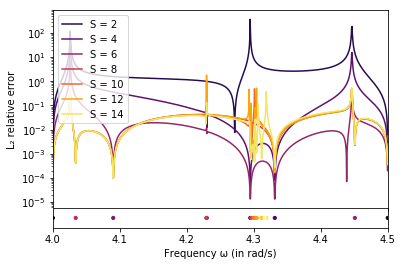

In [70]:
fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True, gridspec_kw={'height_ratios': [10, 1]})

VS = VectorSpaceL2(RC, inlet())

omegas = np.linspace(a, b, 1000)
linspace = np.linspace(a-(b-a)/2000, b+(b-a)/2000, 1001)
RC.solve(linspace)
u_linspace = RC.get_solution(trace=VS.get_trace())

MRI = MinimalRationalInterpolation(VS)
n_iter = 16
surrogate_history = MRI.compute_surrogate(RC, omegas, greedy=True, n_iter=n_iter, return_history=True)

# FOR PLOTTING ONLY
norms = []
n_supp = range(n_iter - 1)[2::2]
for i in n_supp:
    RI = surrogate_history[i-2]
    norms.append(helpers.plot_surrogate_error_norms(ax[0], RC, MRI, VS, u_linspace, linspace, RI,
        label='S = {}'.format(i), color=cm(i/(n_iter-1))))
nodes = MRI.u_ring.get_nodes()
ax[1].scatter(nodes, np.zeros_like(nodes), s=10, c=cm(np.arange(len(nodes))/(n_iter-1)), zorder=-n_iter)
ax[0].set_ylabel('L\u2082 relative error')
ax[1].set_xlabel('Frequency \u03C9 (in rad/s)')
ax[1].set_xlim(a, b)
ax[1].set_yticks([])
ax[0].legend()
plt.subplots_adjust(wspace=0, hspace=0)

In [71]:
with open(root + '/report/plots/rectangular_cavity_trace_errorprogression.pkl', 'wb') as f:
    pickle.dump([norms, linspace, n_supp, n_iter, nodes, a, b], f) 

## Compare eigensolver to rational interpolation

In [137]:
Lx, Ly = 5.0, 1.0
m = 1
g_N = fen.Expression('sin(x[1]*m*pi/Ly)', degree=2, Ly=Ly, m=m)

a = 3
b = 5
omegas = np.linspace(a, b, 100)

for N in np.logspace(3, 6, 4, dtype=int):
    RC = RectangularCavity(Lx=Lx, Ly=Ly, Nx=int(pow(N*Lx/(Lx+Ly), 0.5)), Ny=int(pow(N*Ly/(Lx+Ly), 0.5)), g_N=g_N)
    RC.setup()
    print(50*'#' + '\nRectangular cavity with {} DOFs\n'.format(RC.V.dim()) + 50*'-')
    VS = VectorSpaceL2(RC)
    eigfreqs_analytical = np.array(RC.get_analytical_eigenfrequencies(a, b))
    eigfreqs_numerical = np.array(RC.get_numerical_eigenfrequencies(a, b, k=6))
    print('eigsh')
    %timeit RC.get_numerical_eigenfrequencies(a, b)
    print('Mean absolute error {}'.format(np.mean(np.abs(eigfreqs_analytical - eigfreqs_numerical))))
    MRI = MinimalRationalInterpolation(VS)
    MRI.compute_surrogate(RC, omegas=omegas, greedy=True, tol=1e-2, solver='fenics') 
    eigfreqs_rational_unfiltered = MRI.get_interpolatory_eigenfrequencies()
    eigfreqs_rational = np.sort([np.real(e) for e in eigfreqs_rational_unfiltered[np.abs(np.imag(eigfreqs_rational_unfiltered)) < 1e-10] if a <= e and e <= b])
    print('MRI')
    %timeit MRI.compute_surrogate(RC, omegas=omegas, greedy=True, tol=1e-2, solver='fenics') ; MRI.get_interpolatory_eigenfrequencies()
    print('Mean absolute error {}'.format(np.mean(np.abs(eigfreqs_analytical - eigfreqs_rational))))

##################################################
Rectangular cavity with 713 DOFs
--------------------------------------------------
Increase parameter "k" to ensure all eigenvalues are found.
eigsh
25.9 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Mean absolute error 0.019501121221686974
MRI
61.9 ms ± 3.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Mean absolute error 0.019501804386025185
##################################################
Rectangular cavity with 7412 DOFs
--------------------------------------------------
Increase parameter "k" to ensure all eigenvalues are found.
eigsh
199 ms ± 9.96 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Mean absolute error 0.0018259848240658922
MRI
410 ms ± 16.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Mean absolute error 0.0018267199206235911
##################################################
Rectangular cavity with 74722 DOFs
--------------------------------------------------
Increa